# Tubes ML - DBSCAN

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import classification_report, accuracy_score

In [9]:
iris = datasets.load_iris()
data = iris.data
target = iris.target

In [10]:
def evaluate(labels):
    print(classification_report(target, labels))
    print('accuracy = ', accuracy_score(target, labels, normalize=True))

### Konsep DBSCAN

Density-based Spatial Clustering of Applications with Noise (DBSCAN) secara sederhana merupakan algoritma clustering yang menggunakan konsep density reachability. DBSCAN sedikit mirip dengan K-Means dan K-Medoids karena menggunakan atribut posisi setiap data kemudian menghitung jarak antar data sebagai acuan untuk melakukan clustering.

Konsep density reachability menggunakan 2 parameter yaitu epsilon dan min_pts, dengan penjelasan pada poin-point berikut:

1. Suatu point `p` dinyatakan sebagai core point jika terdapat sejumlah `n` point dimana `n` >= min_pts dan jarak antara `p` dengan poin tersebut kurang dari epsilon (directly-density reachable)
2. Suatu point `q` dinyatakan directly-density reachable dari point `p` jika jarak diantara keduanya kurang dari epsilon dan `p` adalah core point
3. Suatu point `q` dinyatakan reachable dari point `p` jika terdapat path p1, p2, ..., pN dimana `p1 = p` dan `pN = q`, dimana pI+1 directly-density reachable dari pI dan semua point dalam path merupakan core point
4. Seluruh point yang tidak reachable dari point lainnya dinyatakan sebagai outliers

Pseudocode dari implementasi DBSCAN dapat dilihat sebagai berikut:

```sh
    DBSCAN(eps, minPts, D) {
        C = 0
        for each point P in D {
            if label(P) ≠ undefined then
                continue
            Neighbour NP = getNeighbours(D, P, eps)
            if |NP| < minPts then
                label(P) = noise
            else {
                C = C + 1
                label(P) = C
                set S = NP / {P}
                for each point Q in S {
                    if label(Q) = noise then
                        label(Q) = C
                    if label(Q) ≠ undefined then
                        continue
                    label(Q) = C

                    Neighbour NQ = getNeighbours(D, Q, eps)
                    if |NQ| >= minPts then
                    S = S U NQ
                }
            }
        }
    }
```

Berikut merupakan pseudocode dari implementasi fungsi getNeighbours:

```sh
    getNeighbours(D, P, eps)
       neighbours = empty list
        
       for each point Q in D {
           if distance(P,Q) <= eps then {
               neighbours = neighbours U {Q}
           }
       }
        return neighbours
```

In [22]:
class MyDBSCAN(BaseEstimator, ClusterMixin):
    
    def __init__(self, min_pts=4, eps=0.25):
        self.min_pts = min_pts
        self.eps = eps
    
    def __get_neighbours(self, D, P): # fungsi untuk mendapatkan seluruh point yang density-reachable (konsep 1 & 2)
        neighbours = []
        
        for Pt in range(0, len(D)):
            if np.linalg.norm(D[P] - D[Pt]) < self.eps:
                neighbours.append(Pt)
        
        return neighbours 
    
    def __expand_clusters(self, D, P, N, C, labels): # fungsi untuk mendapatkan seluruh point yang reachable (konsep 3)
        i = 0
        
        while i < len(N):
            Pn = N[i]
            
            if labels[Pn] == -1:
                labels[Pn] = C
            elif labels[Pn] == 0:
                labels[Pn] = C
                
                pn_neighbours_pts = self.__get_neighbours(D, Pn)
                if len(pn_neighbours_pts) >= self.min_pts:
                    N = N + pn_neighbours_pts
            
            i += 1
        
    def fit_predict(self, D, y=None):
        cluster_labels = np.zeros(len(D))
        current_cluster = 0
        
        for P in range(0, len(D)):
            if cluster_labels[P] != 0:
                continue
            
            neighbours_pts = self.__get_neighbours(D, P)
            if len(neighbours_pts) < self.min_pts:
                cluster_labels[P] = -1
            else:
                current_cluster += 1
                cluster_labels[P] = current_cluster
                self.__expand_clusters(D, P, neighbours_pts, current_cluster, cluster_labels)
        
        for i in range(0, len(cluster_labels)):
            if cluster_labels[i] > 0:
                cluster_labels[i] -= 1
        return cluster_labels
        

### Penjelasan Kode

Secara teknis, kode dibuat berdasarkan pseudocode yang telah dijelaskan sebelumnya. Perbedaannya disini terdapat 1 fungsi tambahan yaitu `__expand_clusters` untuk menerapkan konsep ke-3 dari DBSCAN, mendapatkan point-point yang reachable dari sebuah core point.

Keluaran dari fungsi `fit_predict` langsung berupa array label data sebagai hasil clustering.

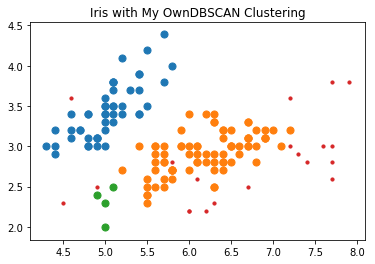

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00         0
        0.0       1.00      0.96      0.98        50
        1.0       0.55      0.86      0.67        50
        2.0       0.00      0.00      0.00        50

avg / total       0.52      0.61      0.55       150

accuracy =  0.606666666667


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
myDBSCAN = MyDBSCAN(eps=0.425)
prediction = myDBSCAN.fit_predict(data)

plt.scatter(data[prediction == 0, 0], data[prediction == 0, 1], s=50)
plt.scatter(data[prediction == 1, 0], data[prediction == 1, 1], s=50)
plt.scatter(data[prediction == 2, 0], data[prediction == 2, 1], s=50)

# Tag Outliers
plt.scatter(data[prediction == -1, 0], data[prediction == -1, 1], s=10)

plt.title('Iris with My OwnDBSCAN Clustering')
plt.show()

evaluate(prediction)

### Penjelasan Hasil Clustering

Seperti yang telah diperlihatkan diatas, ada grafik persebaran data beserta warna yang memisahkan per cluster serta titik kecil untuk data-data outliers. Untuk evaluasi dari algoritma DBSCAN ini sendiri, sudah diperlihatkan diatas mulai dari Precision, Recall, F1-Score, hingga Accuracy nya.

Secara teknis hasil DBSCAN ini cukup memuaskan karena dapat mencapai akurasi 60,67%. Hasil ini bisa didapat tentunya dengan menentukan konfigurasi yang cukup tepat dari DBSCAN itu sendiri, yaitu `epsilon` dan `minPts`. Seharusnya bisa didapatkan hasil yang lebih baik dengan konfigurasi yang lebih detail. Tetapi hal tersebut cukup sulit untuk diterapkan karena tidak ada metode yang pasti untuk penentuan angka `epsilon` dan `minPts`, masih terlalu spekulatif untuk bisa menentukan konfigurasi maksimal dari DBSCAN untuk data iris.